# LCP Final Project - 1

## Introduction 

We are presented with a dataset obtained by four drift-tube detectors during a beam test. The detectors are filled with a gas mixture and they are divided in four layers, each made of cells with an anodic wire sitting at the center; their purpose is to measure the time of flight of $e^-$ drifting towards the anode after the gas has been ionized by the passage of particles through it.

The main purpose of our research is to study properties of $\mu^+ - \mu^-$ pairs produced by positrons colliding at $E=45$ GeV energy onto a Berillium target. 

The data-taking process consists of two phases: a calibration one, where only $\mu^+$ at given energies are employed; the sign of the current powering the magnet is changed so as to have alternance of track directions; the second phase is the Physics one, with the actual results to be extracted.

## Data format

The data files are organized as a series of events where each event consists of a row of said files. These rows are stored in a recursive way so that they can be properly processed so as to obtain data in a readable and usable format for further analysis.
<br>
In particular, the pieces of information we have at disposal are the following:
* event number
* number of recorded hits (N)
* hit $1, ..., N$ coordinates, where for each hit we have
    - *chamber*, which of the four detector registered the hit (numbering is in the range $0-4$)
    - *layer*, layer of that detector that was hit
    - *$x_{left}$*, the $x$ position of the hit assuming the track passed at the left of the wire
    - *$x_{right}$*, the $x$ position of the hit assuming the track passed at the right of the wire
    - *time*, the drift time (redundant)

Notice that N can in principle also be 0, in which case we will obtain an empy dataframe to be initialized with `NaN` values.

## Spatial coordinates

Our spatial quantities are all expressed in the local coordinates of the chamber, defined with respect to one side (the left one) of the chamber itself. All the subdetectors however were placed with a rotation of 180 degrees, which implies the $x$-axis of the local and global coordinates will end up having opposite orientations.
<br>
Below, we summarize all the quantities that will be needed to properly translate the coordinates in due time.

```Python
#Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]
```

## Packages imports

In [1]:
# IPython objects
from IPython.display import display, Markdown

# Data analysis libraries
import numpy as np
np.random.seed(2020)
import pandas as pd
from scipy.stats import norm

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
hist_kwargs = {"edgecolor":"black"}

# others
from glob import glob
from tqdm.autonotebook import tqdm

# analysis functions
from Functions import *

#data_path = "../data/"

/Users/gianmarcopompeo/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Calibration

In the data-taking process, Calibration runs were taken by shooting directly positive muons at a given energy on the target. Only in this scenario, we have single tracks on **either of the two sides** of the apparatus, with the side being determined by the sign of the current powering the magnet.
<br>
We use these events to perform preliminary analysis and test our selection criteria and the overall planning of the Physics analysis. 

In [2]:
calibration_files = glob("./data_merged/calibration/*") # glob(data_path+"data_merged/calibration/*")


In [3]:
def Open_File_Calibration(data_file):
    with open(data_file) as f:
        tot_ev = len(list(f))

    # loop over events and perform analysis
    Ev_list = []
    selected_ev = 0
    with open(data_file) as f:
        with tqdm(total=tot_ev) as pbar:
            for line in f:
                # read event
                ev, evNum, hits = Read_Data(line)
                # select event
                sel, chambers, n_layers = Select_Events_Calibration(ev, hits)
                
                if sel: selected_ev += 1

                # save most important information, in order to plot or reperform the analysis
                # without reading the whole file again
                Ev_list.append(
                    {
                        "Number"    : evNum,
                        "Dataframe" : ev,
                        "Hits"      : hits,
                        "Accepted"  : sel,
                        "Chambers"  : chambers,
                        "Layers"    : n_layers
                    }
                )

                pbar.update()
                
    print("{:35} = {:d}"    .format("Total number of events in the Run", tot_ev))
    print("{:35} = {:d}"    .format("Number of accepted events"        , selected_ev))
    print("{:35} = {:.4f} %".format("Fraction of accepted events"      , selected_ev/tot_ev*100))
    return Ev_list

In [4]:
def Calibration(Ev_list):
    tot_ev = len(Ev_list)
    selected_ev = 0
    # number of hits per event
    hits_number = []
    # residuals from good events fit
    Ev_residuals = []
    # x position of the best combinations of points per chamber
    X_position = {"up" : [], "down" : []}
    # local fit differences between chambers
    lf_diff = {"slope" : [], "intercept" : []}
    
    print("Performing fit and analysis")
    with tqdm(total=tot_ev) as pbar:
        for event in Ev_list:
            hits_number.append(event["Hits"])
            if event["Accepted"]:
                selected_ev += 1
                ev = event["Dataframe"]
                chambers = event["Chambers"]
                n_layers = event["Layers"]
        
                #Local linear fit
                lf_results = Local_Fit(ev, chambers, n_layers, exclusion_layer=True)
                #Global linear fit
                gf_results = Global_Fit_Calibration(ev, chambers, lf_results)
                Ev_residuals.append(gf_results["residuals"])

                # x coordinates for the points in the optimal combination after local fit per chamber
                X_position["up"]   += [x[1] for x in lf_results[0]["optimal_comb"]]
                X_position["down"] += [x[1] for x in lf_results[1]["optimal_comb"]]
                # local fit differences
                lf_diff["slope"]    .append(lf_results[0]["slope"]    -lf_results[1]["slope"])
                lf_diff["intercept"].append(lf_results[0]["intercept"]-lf_results[1]["intercept"])
            
            pbar.update()
            
    display(Markdown("#### Hit distribution"))
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(hits_number, bins=14, range=(0,70), **hist_kwargs)
    ax.set_xlabel("number of hits")
            
    display(Markdown("#### Hit position (cell local coordinates)"))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)

    ax1.set_title("Up")
    ax1.hist(X_position["up"]    , bins=30, **hist_kwargs)
    ax1.set_xlabel("x [mm]")

    ax2.set_title("Down")
    ax2.hist(X_position["down"], bins=30, **hist_kwargs)
    ax2.set_xlabel("x [mm]")

    plt.show()
    
    display(Markdown("#### Difference in slope and intercept between chambers (local fits)"))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)

    ax1.set_title("Difference in local slopes")
    Gaussian_Fit_Hist(ax1, lf_diff["slope"],     nbins=30, hist_range=(-0.5,0.5), **hist_kwargs)
    ax1.set_xlabel("$\Delta$ slope []")

    ax2.set_title("Difference in local intercepts")
    Gaussian_Fit_Hist(ax2, lf_diff["intercept"], nbins=30, hist_range=(-100,100), **hist_kwargs)
    ax2.set_xlabel("$\Delta$ intercept [mm]")
    
    plt.show()
    
    display(Markdown("#### Residuals in the excluded layer"))
    
    Hit_6_layers = 0
    Hit_7_layers = 0
    Hit_8_layers = 0
    Tot_res      = []
    
    for res in Ev_residuals:
        if len(res) == 0:
            Hit_6_layers += 1
        elif len(res) == 1:
            Hit_7_layers += 1
        elif len(res) == 2:
            Hit_8_layers += 1
        else: continue
        Tot_res += res.tolist()

    fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
    ax1.set_title("Residuals of the points in the excluded layers")
    Gaussian_Fit_Hist(ax1, Tot_res, nbins= 30, hist_range=(-20,20), **hist_kwargs)
    ax1.set_xlabel("Residuals [mm]")
    
    labels = ['Hit in 8 layers', 'Hit in 7 layers', 'Hit in 6 layers']
    sizes  = [Hit_8_layers/len(Ev_residuals)*100, 
              Hit_7_layers/len(Ev_residuals)*100, 
              Hit_6_layers/len(Ev_residuals)*100]
    patches, _, _ = ax2.pie(sizes, labels=labels, explode = [.05,.05,.05], autopct='%1.1f%%', shadow=True,
                               wedgeprops={"edgecolor":'black', "linewidth":1.25})
    ax2.legend(patches, labels, loc='upper right', fontsize=14)
    ax2.axis('equal')
    ax2.set_title("Presence of hits in layers")
    
    plt.show()
            
    return Ev_residuals, X_position, lf_diff

### Run 260: E = 22 GeV; $i$ = -580 A

#### Reading data

In [5]:
Ev_list = Open_File_Calibration(calibration_files[0])


Total number of events in the Run   = 4070
Number of accepted events           = 1355
Fraction of accepted events         = 33.2924 %


Performing fit and analysis


#### Hit distribution

#### Hit position (cell local coordinates)

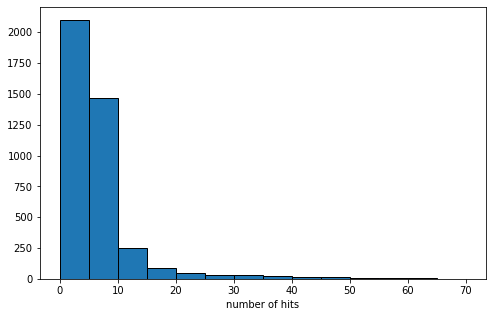

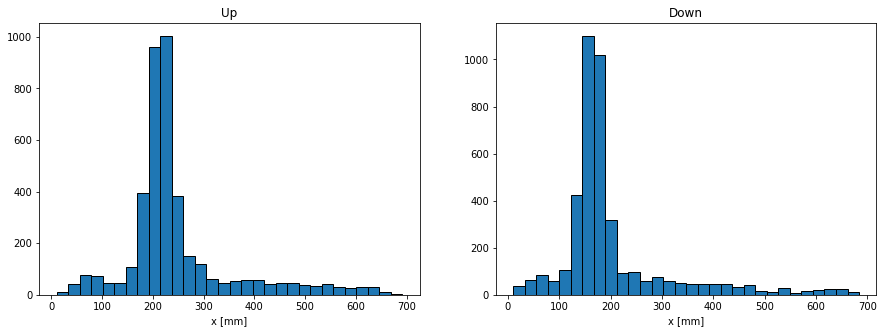

#### Difference in slope and intercept between chambers (local fits)

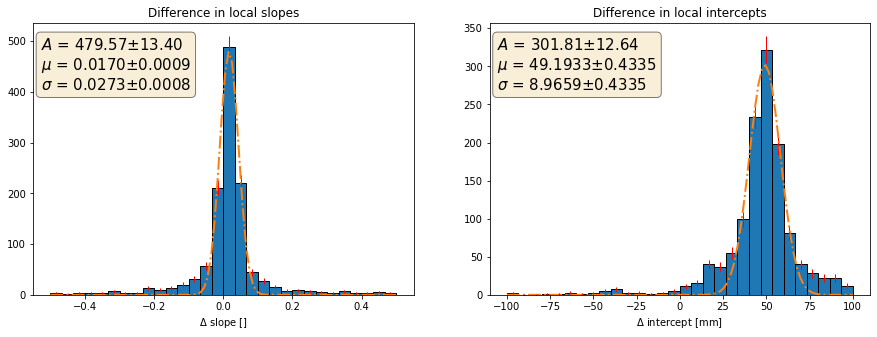

#### Residuals in the excluded layer

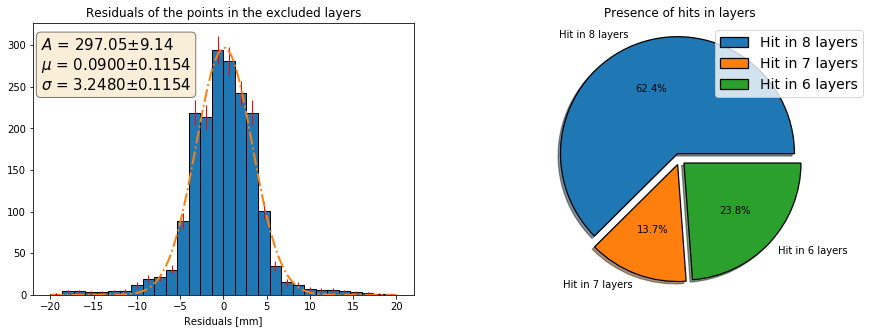

In [6]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 261: E = 18 GeV; $i$ = -850 A

#### Reading data

In [7]:
Ev_list = Open_File_Calibration(calibration_files[1])


Total number of events in the Run   = 8182
Number of accepted events           = 1981
Fraction of accepted events         = 24.2117 %


Performing fit and analysis


#### Hit distribution

#### Hit position (cell local coordinates)

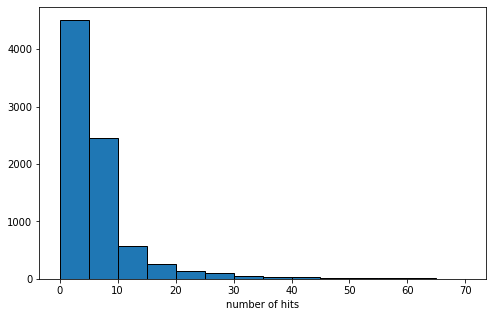

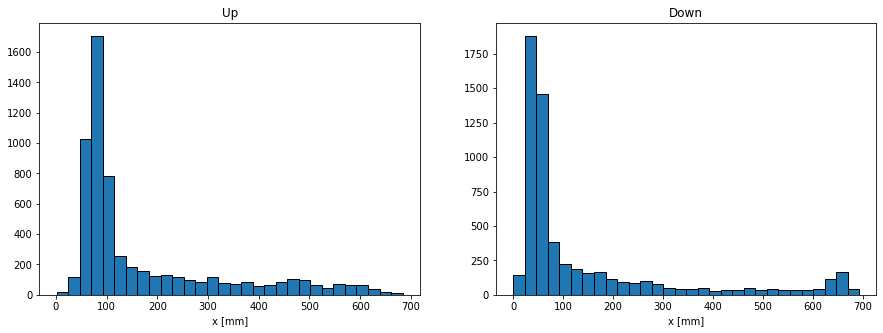

#### Difference in slope and intercept between chambers (local fits)

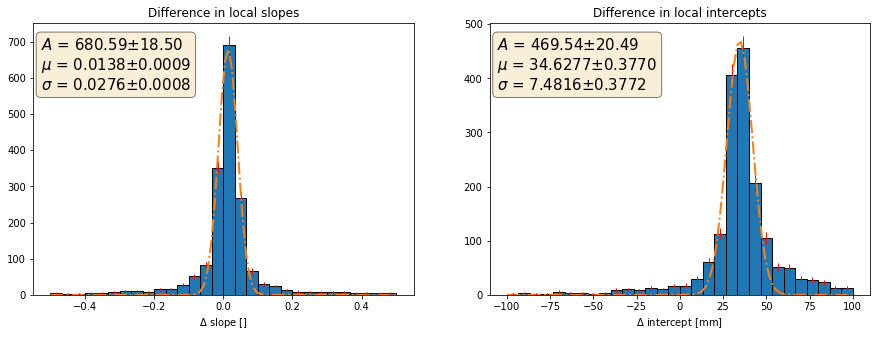

#### Residuals in the excluded layer

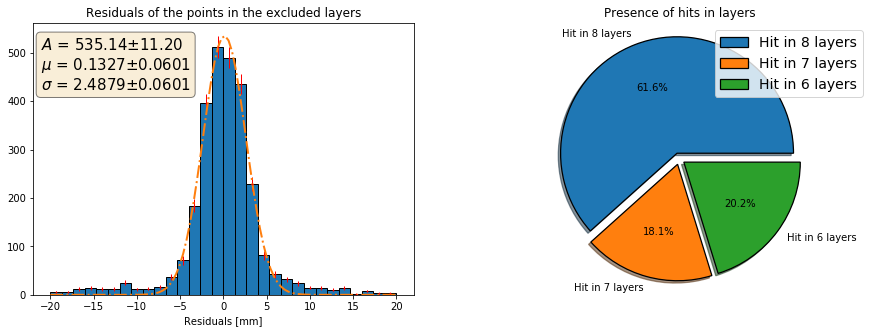

In [8]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 262: E = 18 GeV; $i$ = 850 A

#### Reading data

In [9]:
Ev_list = Open_File_Calibration(calibration_files[2])


Total number of events in the Run   = 5367
Number of accepted events           = 1467
Fraction of accepted events         = 27.3337 %


Performing fit and analysis


#### Hit distribution

#### Hit position (cell local coordinates)

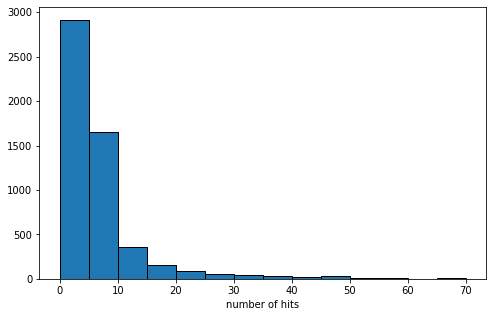

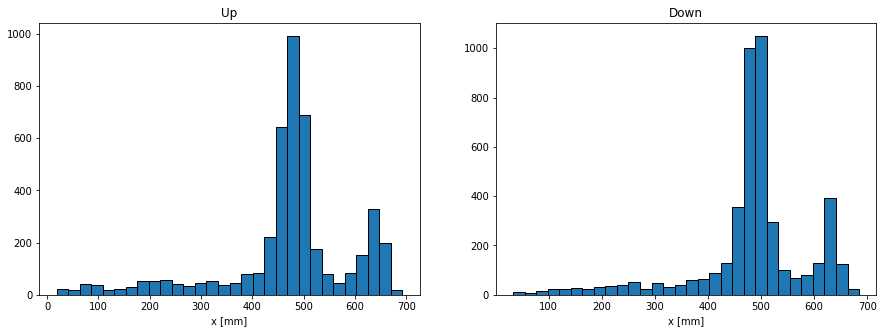

#### Difference in slope and intercept between chambers (local fits)

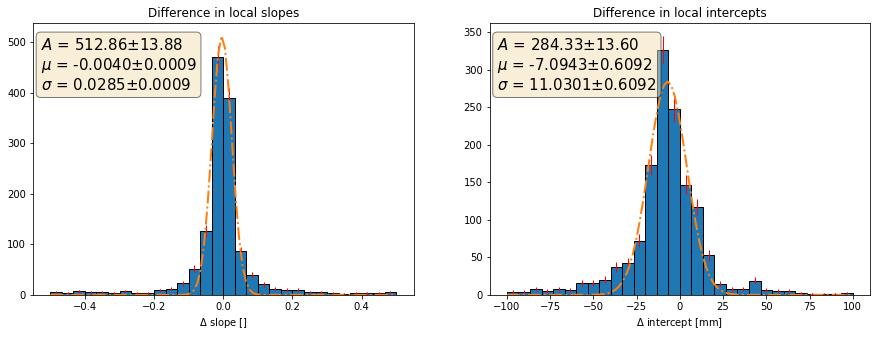

#### Residuals in the excluded layer

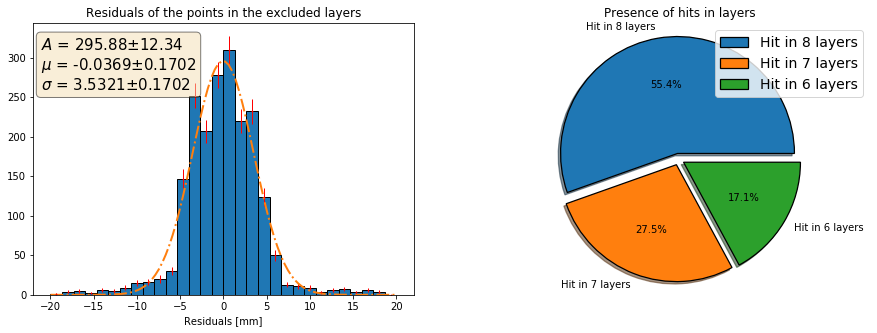

In [10]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 263: E = 22 GeV; $i$ = 580 A

#### Reading data

In [11]:
Ev_list = Open_File_Calibration(calibration_files[3])


Total number of events in the Run   = 1502
Number of accepted events           = 316
Fraction of accepted events         = 21.0386 %


Performing fit and analysis


#### Hit distribution

#### Hit position (cell local coordinates)

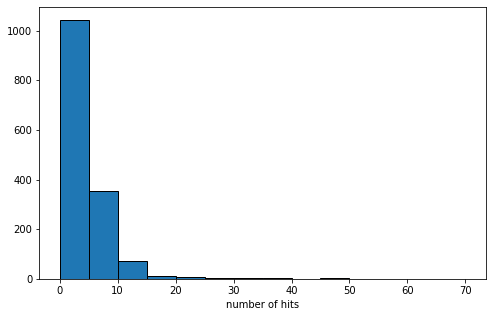

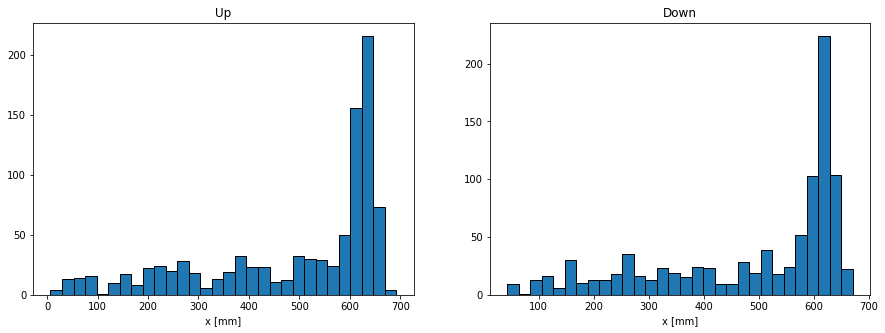

#### Difference in slope and intercept between chambers (local fits)

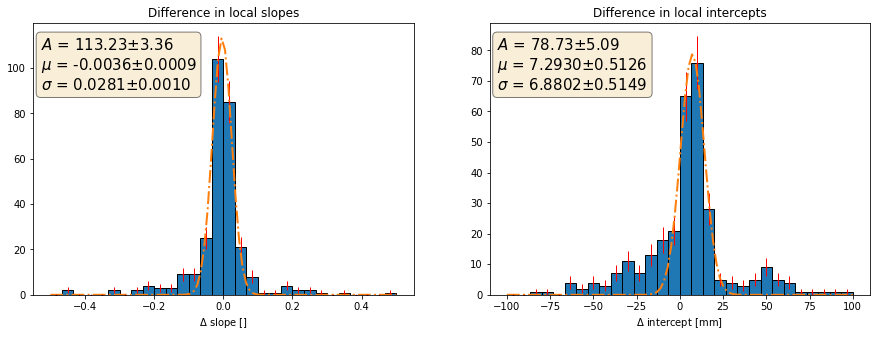

#### Residuals in the excluded layer

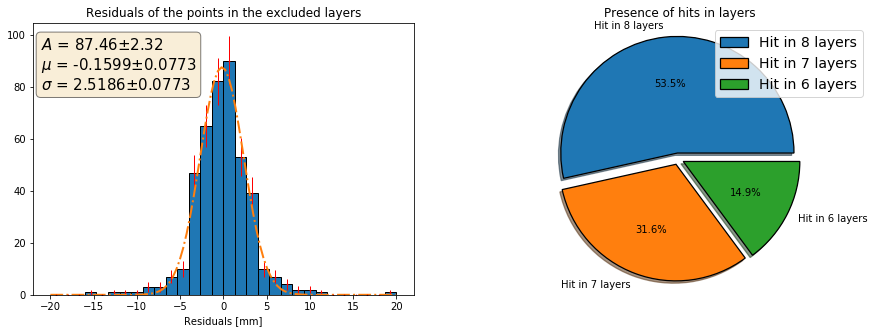

In [12]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Event display

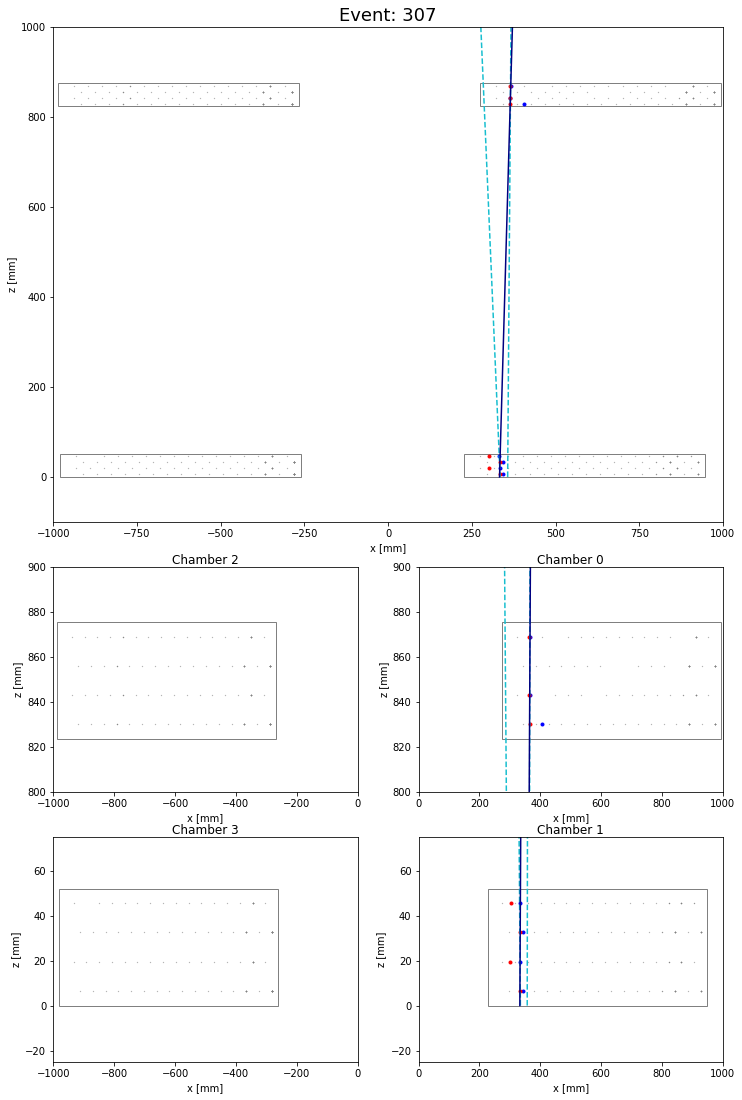

In [13]:
Make_Plot(Ev_list[295], calibration=True)

## Summary

The distribution of the number of hits is highly peaked for values below $10$, which shows that the selection we applied is sensible. 

We also built histograms to study the distributions of the hits position-wise, in order to make sure that the regions of interest are the ones that were in fact highlighted in the data presentation. We see that these distributions are peaked according to the magnetic field at which each Run is executed, in particular keeping faith to the left/right expectation. In particular, in Run $262$ we notice a slightly double-peaked structure, whose presence we are not able to fully explain.

In the distributions of the differences between the slopes and the intercepts obtained from the local fits, we see that the former is centered in $0$, as expected. This is a good sign, as it indicates that the points representing the hits do lay on the same global straight line and this further validates the global fit we perform. 
<br>
On the other hand, the fact that the differences in intercepts are centered around $40$ (although slightly dependent on the Run) for the left part of the detector may show a problem in the position of the chambers, possibly due to a disalignment. This effect is not shown on the right subdetectors.

Finally, the absolute residuals computed with respect to the excluded layer have a clearly defined gaussian shape with mean $0$, which is exactly what we would have expected. This strengthens the choice of our points as the best combination.